In [315]:
%load_ext autoreload
%autoreload 2
import numpy as np # math
import matplotlib.pyplot as plt # graphs and plots
import pandas as pd
from tqdm import tqdm
import datetime
import matplotlib.dates as mdates
from src.utils.profiles_from_schedule_new import SimParam # class for show-up generator
from src.simfunc.KIX_T1d_CUSBD_new import Pax, Simulation # classes for simulation
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [316]:
simparam = SimParam()
path_to_6k_sched = (
    r"/home/antoine/projects/"
    "KAPpaxsim/KAPpaxsim/data/"
    "processed/Schedule (30th terminal peak, 6000 pax)_PROCESSED.xlsx"
)
simparam.schedule_from_path(path_to_6k_sched)
simparam.schedule_cleanup()
simparam.schedule_filter()
simparam.show_up_from_file()
simparam.assign_flight_show_up_category_default()
# simparam.plot_show_up_categories_profiles()
simparam.schedule['PAX_SUM FC'] = 10
simparam.assign_show_up()
# simparam.plot_df_Pax()
simparam.assign_check_in()

In [317]:
# simparam.df_Counters['total'].plot()

In [318]:
simparam.dct_resource = {
    'kiosk' : 92,
    'security' : 200,
    'CUSBD' : 192,
}

simparam.dct_processes = {
    'kiosk' : 70,
    'security': 1,
    'CUSBD': 60,
    'checkin': 70,
}

In [321]:
simulation = Simulation(simparam)
simulation.generate_checkin()
simulation.generate_pax()
simulation.run()

Simulation running...: 100%|██████████| 1439/1439 [01:18<00:00, 18.39it/s] 


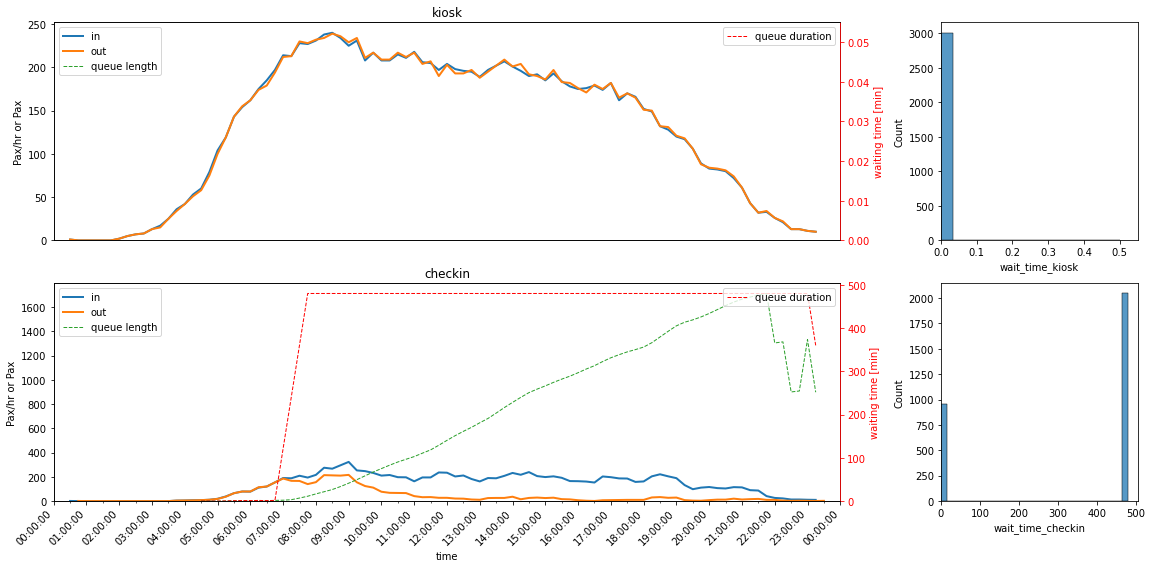

In [322]:
simulation.format_df_result()
simulation.plot_result()